## Note for the TA's:
<u>**Report is present in the notebook along with all the plots.**</u>
---


# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [ ]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [457]:
# Basic Imports
import os
import sys
import copy
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Others
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,confusion_matrix


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [458]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [459]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [460]:
# Loading the dataset1
dirpath1 = './dataset/IMFDB/'
X1,y1 = load_data(dirpath1)
N1,H1,W1 = X1.shape[0:3]
C1 = 1 if opt['is_grayscale'] else X1.shape[3]

# Loading the dataset2
dirpath2 = './dataset/IIIT-CFW/'
X2,y2 = load_data(dirpath2)
N2,H2,W2 = X2.shape[0:3]
C2 = 1 if opt['is_grayscale'] else X2.shape[3]

# Loading the dataset3
dirpath3 = './dataset/Yale_face_database/'
X3,y3 = load_data(dirpath3)
N3,H3,W3 = X3.shape[0:3]
C3 = 1 if opt['is_grayscale'] else X3.shape[3]


Dataset shape: (400, 32, 32)
Dataset shape: (672, 32, 32)
Dataset shape: (165, 32, 32)


In [461]:
#Show/Compare sample images
def di(X1,X2,y1):
    """
    Display original images along with
    reconstructed ones.
    """
    N,R,C=[10,1,10]
    ind=np.random.randint(0,y1.shape[0],N)
    disply_images(X1[ind,...],y1[ind],row=R,col=C)
    disply_images(X2[ind,...],y1[ind],row=R,col=C)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [270]:
# Flatten to apply PCA/LDA
# X = X.reshape((N,H*W*C))


###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [6]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k1 = pca.fit_transform(X)
    X_k2 = pca.inverse_transform(X_k1)
    return X_k1,X_k2

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [7]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [8]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [9]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [10]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [11]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________
Eigen faces refers to eigen vectors when they are used in computer vision problem of human face recognition. They are used as basis for every image which helps in dimensionality reduction by allowing smaller set of basis to represent every image. So basically eigen faces is a fancy name given to eigen vectors when the data points we are working with are images.
___________________________
___________________________


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.
___________________________
So we can decide on the eigen vectors by looking at the eigen value spectrum. Most eigen vectors are close to zero and only few of them are significant which reconstruct the image almost perfectly. To get the number of eigen vectors by looking at the eigen value spectrum, we can take the eigen vectors to the point where the spectrum almost becomes zero. We could also take the eigen vectors which contain >95% information. Verification could be done by calculating the error in original and reconstructed image.


In [446]:
# Compute your features 

def compute_features(X,N,H,W,C,K):
    X=X.reshape((N,H*W*C))
    Xk,Xkt=get_pca(X,K)
    print(Xk.shape)

# eigen vectors based on eigen value spectrum
compute_features(X1,N1,H1,W1,C1,60)
compute_features(X2,N2,H2,W2,C2,130)
compute_features(X3,N3,H3,W3,C3,20)

(400, 60)
(672, 130)
(165, 20)


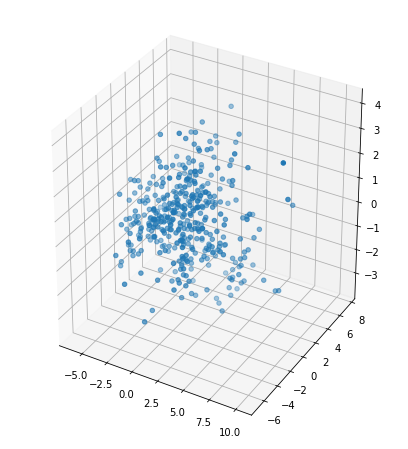

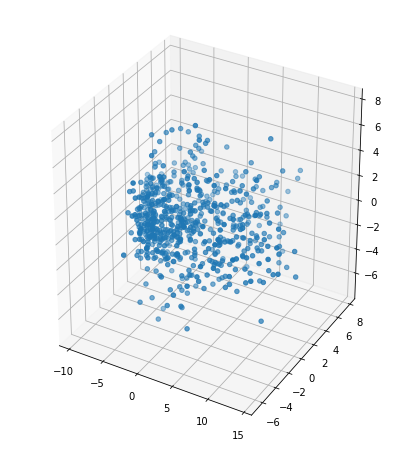

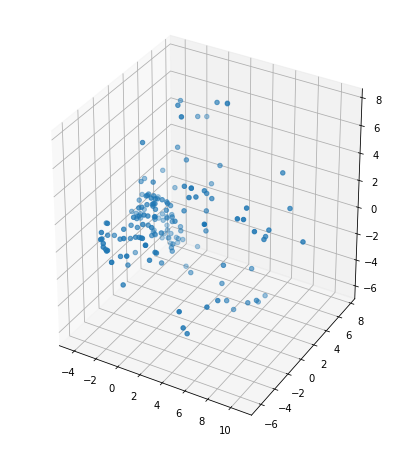

In [34]:
# Create a scatter plot(3D)  

def create_scatter(X,N,H,W,C,p):
    X=X.reshape((N,H*W*C))
    X,j=get_pca(X,3)
    fig = plt.figure(figsize=(24,8))
    ax = fig.add_subplot(p, projection='3d')
    ax.scatter(X[:,0],X[:,1],X[:,2])

create_scatter(X1,N1,H1,W1,C1,131)
create_scatter(X2,N2,H2,W2,C2,132)
create_scatter(X3,N3,H3,W3,C3,133)

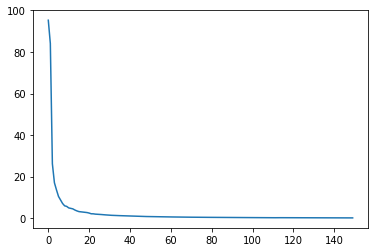

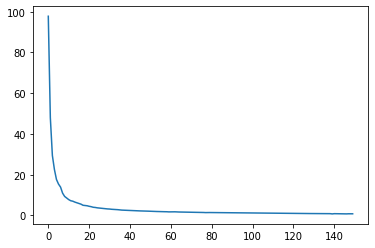

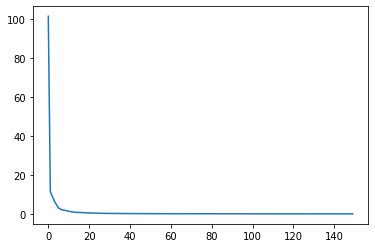

In [442]:
# Plot the eigen value spectrum 

def plot_spectrum(S,X,N,W,H,C):
    a=X.reshape((N,W*H*C))
    C=np.cov(a)
    E=np.linalg.eigvals(C)
    E=E.real
    EM=np.mean(E)
    X=np.arange(S)
    plt.plot(X,E[0:S]/EM)
    plt.show()

v=150
plot_spectrum(v,X1,N1,W1,H1,C1)
plot_spectrum(v,X2,N2,W2,H2,C2)
plot_spectrum(v,X3,N3,W3,H3,C3)

1(c). Reconstruct  the  image  back for each case


In [444]:
def reconstruct_images(X,N,H,W,C,K):
    Xt=X.reshape((N,H*W*C))
    j,Xt=get_pca(Xt,K)
    Xt=Xt.reshape((N,H,W))
    return Xt


RESULT:1
--------



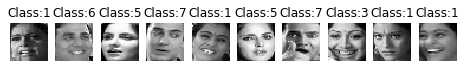

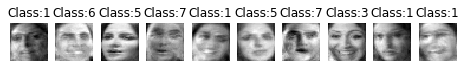

0.05152865298648529

RESULT:2
--------



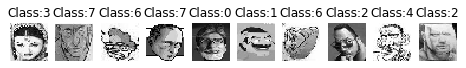

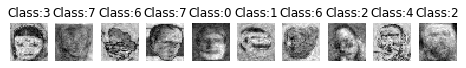

0.11609069881519052

RESULT:3
--------



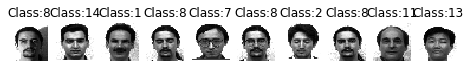

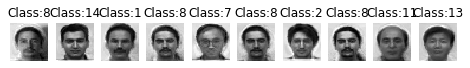

0.09752948197865526


In [462]:
# Display results 
# Display random images
# Show the reconstruction error

X1_reconstruced = reconstruct_images(X1,N1,H1,W1,C1,60)
print("\nRESULT:1")
print("--------\n")
di(X1,X1_reconstruced,y1)
print(np.sqrt(np.mean((X1-X1_reconstruced)**2)))

X2_reconstruced = reconstruct_images(X2,N2,H2,W2,C2,130)
print("\nRESULT:2")
print("--------\n")
di(X2,X2_reconstruced,y2)
print(np.sqrt(np.mean((X2-X2_reconstruced)**2)))

X3_reconstruced = reconstruct_images(X3,N3,H3,W3,C3,20)
print("\nRESULT:3")
print("--------\n")
di(X3,X3_reconstruced,y3)
print(np.sqrt(np.mean((X3-X3_reconstruced)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers
___________________________
**Answer**<br>

<u>For dataset-1</u><br>
Based on maximum error in reconstruction, we get the answer as 3
<br>
<u>Reason</u><br>
When we look at the images present in this dataset, there is lot more variance in the images of class 3 (Shipla Shetty) as compared to any other class. Hence lot many eigen vectors are needed to reconstruct it significantly back and thus it is most difficult to reconstruct back. Also class 3 images are quite different from one another where as other class images are similar to each other. 
<br><br>
<u>For dataset-2</u><br>
Based on maximum error in reconstruction, we get the answer as 5
<br>
<u>Reason</u><br>
When we look at the images present in this dataset, there is lot more variance in the images of all the classes as compared to other datasets. Hence lot many eigen vectors are needed to reconstruct the images significantly back and hence reconstruction error is high for all the images. From the results obtained it so happens that the images of class 5 are reconstructed with least accuracy. 
<br><br>
<u>For dataset-3</u><br>
Based on maximum error in reconstruction, we get the answer as 7
<br>
<u>Reason</u><br>
When we look at the images present in this dataset, all the images of one class are quite similar to one another and hence reconstruction error is very less even with less number of eigen vectors. Error is almost similar for every class and it so happens that we get class 7 with most error.


Among all the datasets, **2nd dataset (IIIT-CFW) is most difficult to represent compactly with fewer eigen vectors**. This is because in this dataset there are lot many images than any other dataset and all these images are very different from each other. Both interclass and intraclass variance is very high which makes it a lot more difficult to represent these images with few eigen vectors. Though we have taken a lot many eigen vectors to reconstruct it back, then also it has maximim reconstruction error.

In [454]:
#dataset-1
D1=np.zeros(8)
C1=np.zeros(8)
for i in range(400):
    C1[y1[i]]+=1
    D1[y1[i]]+=np.mean((X1[i]-X1_reconstruced[i])**2)
print(D1)
print(np.argmax(D1/C1))

#dataset-2
D2=np.zeros(8)
C2=np.zeros(8)
for i in range(672):
    C2[y2[i]]+=1
    D2[y2[i]]+=np.mean((X2[i]-X2_reconstruced[i])**2)
print(D2)
print(np.argmax(D2/C2))

#dataset-3
D3=np.zeros(15)
C3=np.zeros(15)
for i in range(165):
    C3[y3[i]]+=1
    D3[y3[i]]+=np.mean((X3[i]-X3_reconstruced[i])**2)
print(D3)
print(np.argmax(D3/C3))


[0.10297276 0.13062508 0.1280744  0.14658467 0.14385174 0.13418472
 0.13181491 0.14473223]
3
[0.55677639 0.55354997 0.82665727 1.20534521 1.34143349 1.58714761
 1.55283119 1.44232706]
5
[0.10516927 0.09284153 0.11879066 0.07900267 0.08013277 0.09673076
 0.11630447 0.14704602 0.1159849  0.09567388 0.14093352 0.11186183
 0.09733038 0.07213003 0.09945205]
7


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [185]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self,classifier,maxiter=1000,kernel="linear",gamma="auto",degree=3,hidden=(5000,)):
        if(classifier=="SVM"):
            self.classifier=SVC(C=1,max_iter=maxiter,kernel=kernel,gamma=gamma,degree=degree)
        elif(classifier=="LOGISTIC"):
            self.classifier=LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial')
        elif(classifier=="MLP"):
            self.classifier=MLPClassifier(hidden_layer_sizes=hidden)
    
    def classify(self,X):
        prediction=self.classifier.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        cm=confusion_matrix(y,pred)
        return cm
    
    def train(self,X_train,y_train):
        self.classifier.fit(X_train,y_train)

        
    def validate(self,X_validate,y_validate):
        # predict
        pred=self.classify(X_validate)
        # Create a confusion matrix
        cm=self.confusion_matrix(pred,y_validate)
        # Calculate Validation accuracy 
        acc=accuracy_score(y_validate,pred)
        # Calculate precision and recall and F1-score
        precision,recall,f1s,j=precision_recall_fscore_support(y_validate,pred,average="micro")
    
        return [f1s,acc,precision,recall,cm]

In [210]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

def splitdata(X,Y,N):
    #shuffle
    s=np.arange(X.shape[0])
    np.random.shuffle(s)
    X=X[s]
    Y=Y[s]
    #split
    t=(N/10)*8
    t=int(t)
    Xtr=X[0:t]
    Ytr=Y[0:t]
    Xte=X[t:N]
    Yte=Y[t:N]
    return Xtr,Ytr,Xte,Yte


def initfc(X,Y,N,W,H,C,f,c,path):
    #flatten
    X=X.reshape((N,W*H*C))
    
    #select feature
    if(f=="PCA"):
        X,j=get_pca(X,50)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f=="KPCA"):
        X=get_kernel_pca(X,50)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f=="LDA"):
        X=get_lda(X,Y,50)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f=="KLDA"):
        X=get_kernel_lda(X,Y,50)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f=="VGG"):
        X=get_vgg_features(path)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    elif(f=="RESNET"):
        X=get_resnet_features(path)
        Xtr,Ytr,Xte,Yte=splitdata(X,Y,N)
    
    #select classifier
    if(c=="SVM"):
        classifier=Classifier("SVM")
        classifier.train(Xtr,Ytr)
    elif(c=="LOGISTIC"):
        classifier=Classifier("LOGISTIC")
        classifier.train(Xtr,Ytr)
    elif(c=="MLP"):
        classifier=Classifier("MLP",hidden=(50,10))
        classifier.train(Xtr,Ytr)
        
    #testing
    f1s,acc,precision,recall,cm=classifier.validate(Xte,Yte)
    
    #add to list for printing later
    temp=[]
    temp.append(f+" with "+c)
    temp.append(Xtr.shape[1])
    temp.append(1-acc)
    temp.append(acc)
    temp.append(f1s)
    
    return [temp,acc,cm]
        
    
def niceprint1(x):
    cellwidth=25

    #print row seperator
    head=' '
    for i in range(len(x)):
        head+='-'*cellwidth
        head+=' '
    print(head)

    #print each record
    print('|',end='')
    for i in x:
        i=str(i)
        i=i.center(cellwidth)#ljust,rjust,center
        print(i,end='|')

    #print newline after each record
    print()
    

def func(X,Y,N,W,H,C,path,d):
    FEATURES=["PCA","KPCA","LDA","KLDA","VGG","RESNET"]
    CLASSIFIER=["SVM","LOGISTIC","MLP"]
    Table=[]
    Bestcm=[]
    for f in FEATURES:
        for c in CLASSIFIER:
            temp,acc,cm=initfc(X,Y,N,W,H,C,f,c,path)
            Table.append(temp)
            Bestcm.append([acc,cm])

    # printing
    print("Results for dataset-"+str(d))
    Table.insert(0,["Feature","Red dime","Error","Accuracy","F1-score"])
    for i in Table:
        niceprint1(i)
    print("")
    print("")
    return Bestcm

    

bestcm1=func(X1,y1,N1,W1,H1,C1,"./dataset/IMFDB",1)
bestcm2=func(X2,y2,N2,W2,H2,C2,"./dataset/IIIT-CFW",2)
bestcm3=func(X3,y3,N3,W3,H3,C3,"./dataset/Yale_face_database",3)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 8 - 1) = 7 components.
  ChangedBehaviorWarning)


Results for dataset-1
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |         Red dime        |          Error          |         Accuracy        |         F1-score        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with SVM      |            50           |          0.3375         |          0.6625         |          0.6625         |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|    PCA with LOGISTIC    |            50           |           0.35          |           0.65          |           0.65          |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with MLP      |            50           | 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis

Results for dataset-2
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |         Red dime        |          Error          |         Accuracy        |         F1-score        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with SVM      |            50           |    0.5333333333333333   |    0.4666666666666667   |    0.4666666666666667   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|    PCA with LOGISTIC    |            50           |    0.5703703703703704   |   0.42962962962962964   |    0.4296296296296296   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with MLP      |            50           | 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 15 - 1) = 14 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default),

Results for dataset-3
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |         Red dime        |          Error          |         Accuracy        |         F1-score        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with SVM      |            50           |   0.06060606060606055   |    0.9393939393939394   |    0.9393939393939394   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|    PCA with LOGISTIC    |            50           |           0.0           |           1.0           |           1.0           |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|       PCA with MLP      |            50           | 

In [224]:
# For each dataset print the confusion matrix for the best model 
def printcm(X,i):
    print("Confusion Matrix for dataset-"+str(i)+"\n")
    X.sort(key=lambda x:x[0],reverse=True)
    print(X[0][1])
    print("\n")

printcm(bestcm1,1)
printcm(bestcm2,2)
printcm(bestcm3,3)

Confusion Matrix for dataset-1

[[ 9  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0]
 [ 0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0 12]]


Confusion Matrix for dataset-2

[[11  0  0  1  0  0  0  0]
 [ 0 12  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0]
 [ 0  0  1  0 19  0  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 21  0]
 [ 0  0  0  0  0  0  0 13]]


Confusion Matrix for dataset-3

[[3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2]]




## <u>Theory related to this question</u>

### Pipeline
 - Define the Classifier class
    - Initialise different classifiers based on the input given
    - Complete the functions to calculate confusion matrix, classify the data and train the model
    - Validate the model using measures like accuracy, recall and f1-score
 - Apply func() for each dataset
   - Calculate accuracy, precision, f1-score for each pair of feature and classifier for all 18 pairs
 - To calculate best confusion matrix, store all the confusion matrices along with their corressponding accuracies and sort based on the accuracy
 
________________________________________________________________
 _______________________________________________________________________ 

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [421]:
#Apply TSNE

def applytsne(X,N,H,W,C,k):
    X=X.reshape((N,H*W*C))
    X=TSNE(n_components=k).fit_transform(X)
    return X
    
#3D plots
p1=applytsne(X1,N1,H1,W1,C1,3)
p2=applytsne(X2,N2,H2,W2,C2,3)
p3=applytsne(X3,N3,H3,W3,C3,3)

#2D plots
p4=applytsne(X1,N1,H1,W1,C1,2)
p5=applytsne(X2,N2,H2,W2,C2,2)
p6=applytsne(X3,N3,H3,W3,C3,2)

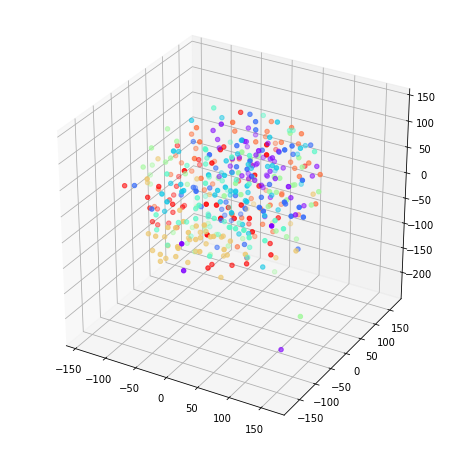

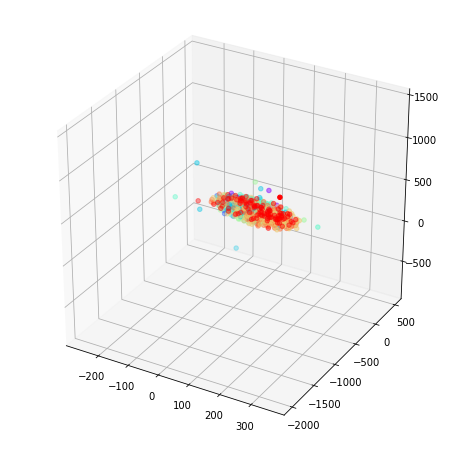

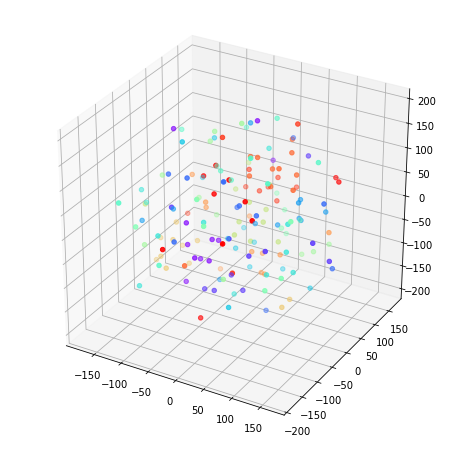

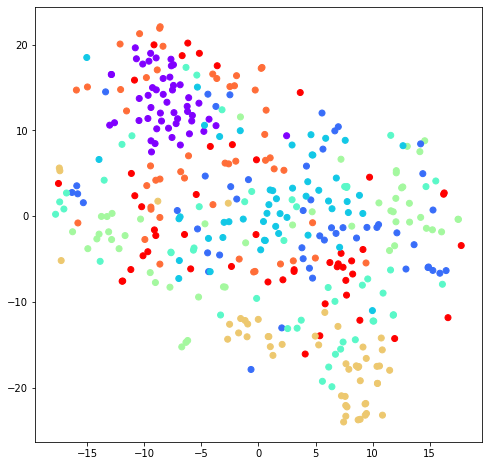

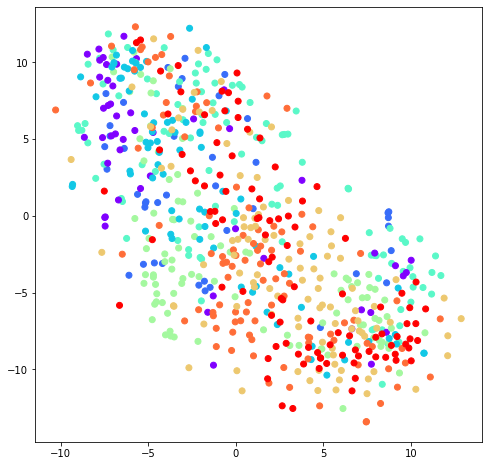

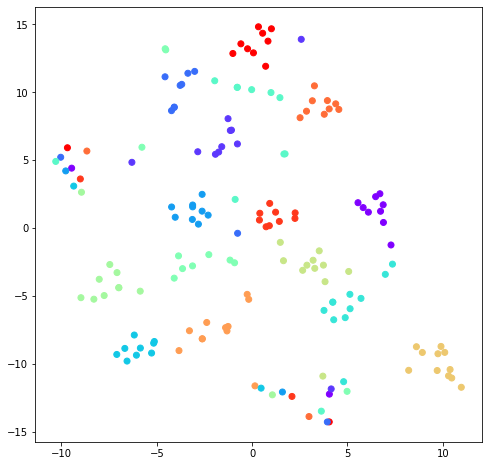

In [456]:
#Show visualization

def pprint(X,Y,k):
    N=np.unique(Y).shape[0]
    C=[0]*len(X)
    colors=cm.rainbow(np.linspace(0, 1, N))
    for i in range(len(Y)):
        C[i]=colors[Y[i]]
    
    if(k==3):
        fig=plt.figure(figsize=(8,8))
        ax=fig.add_subplot(111,projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2],color=C)
        
    if(k==2):
        fig=plt.figure(figsize=(8,8))
        plt.scatter(X[:,0],X[:,1],color=C)


#3D        
pprint(p1,y1,3)
pprint(p2,y2,3)
pprint(p3,y3,3)

#2D
pprint(p4,y1,2)
pprint(p5,y2,2)
pprint(p6,y3,2)

In [423]:
#Combined visualization

#Combine X
Xcomb=np.vstack((X1,X2))
Xcomb=np.vstack((Xcomb,X3))
print(Xcomb.shape)

#Combine Y
t=copy.deepcopy(y2)
for i in range(len(t)):
    t[i]=t[i]+8

Ycomb=np.hstack((y1,t))

t=copy.deepcopy(y3)
for i in range(len(t)):
    t[i]=t[i]+16

Ycomb=np.hstack((Ycomb,t))
print(Ycomb.shape)

#applyTSNE
p7=applytsne(Xcomb,Xcomb.shape[0],H1,W1,C1,3)
p8=applytsne(Xcomb,Xcomb.shape[0],H1,W1,C1,2)

(1237, 32, 32)
(1237,)


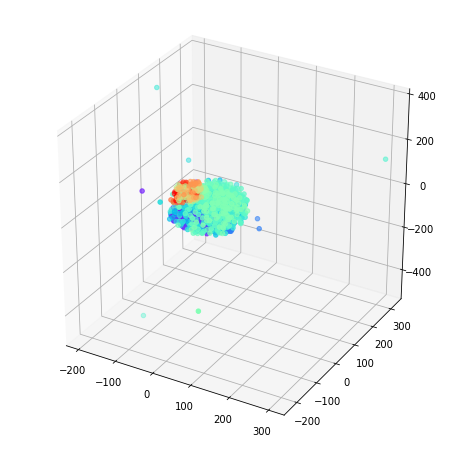

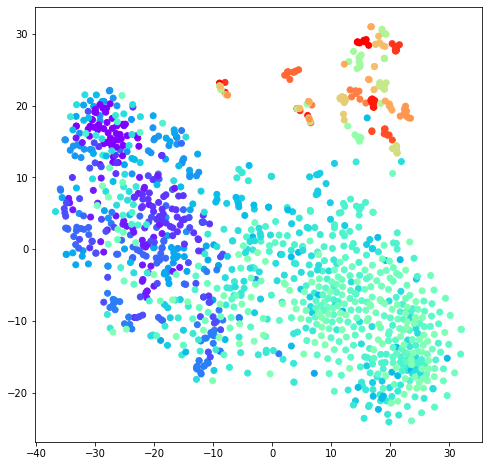

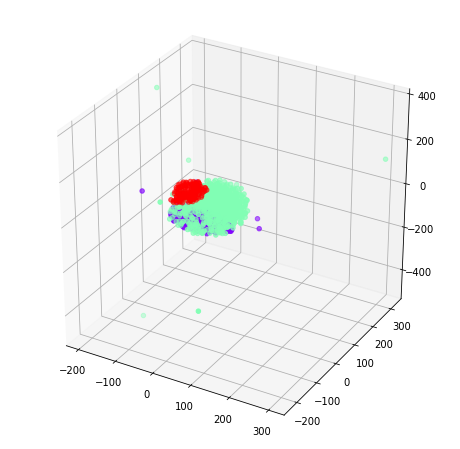

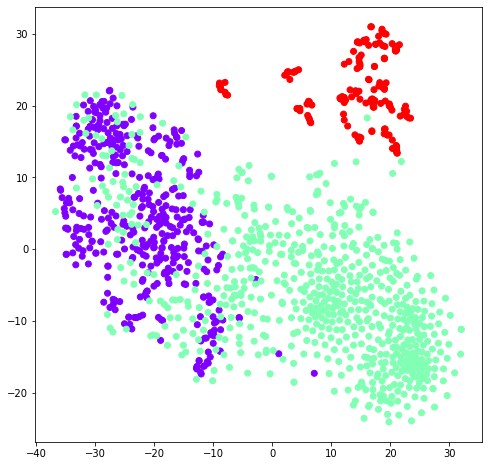

In [439]:
#Show visualization

# A) All 31 classes together
#Since there are 31 classes there is very less variation in the colors
pprint(p7,Ycomb,3)
pprint(p8,Ycomb,2)

# B) 3 classes for 3 datasest
t=[]
for i in range(X1.shape[0]):
    t.append(0)
for i in range(X2.shape[0]):
    t.append(1)
for i in range(X3.shape[0]):
    t.append(2)

pprint(p7,t,3)
pprint(p8,t,2)

## <u>Theory related to this question</u>

### t-SNE
 - t-SNE(t-Distributed stochastic neighbour embedding) is a dimensionality reduction technique that minimizes the divergence between two distributions(distributions that measure pairwise similarity of points in original and reduced space).
 - In this way t-SNE maps data from high dimension space to low dimension space by identifying clusters based on similarity of data points with multiple features.
 - This brings all the points belonging to same cluster close to each other and hence we can easily apply our model of multi-class classification. 
 
### Visualization
 - First plot of each dataset is shown along with class distribution in it (Both 2D and 3D) 
 - Then the plot of combined dataset is shown with all classes (Total 31 classes).
 - Then the combined plot is shown with each dataset as a seperate class
 
Thus we can apply t-SNE as it brings points in one class close to each other. We can see these results when we plot all the samples combined as well as dataset wise. 
________________________________________________________________
 _______________________________________________________________________ 

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 


4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [235]:
# Create a train and validation split and show your results 

def preprocessdata(X,Y,N,H,W,C,f,d,k):
    
    #flatten
    X=X.reshape((N,H*W*C))
    
    #apply reduction
    if(f==0):
        X,j=get_pca(X,k)
    elif(f==1):
        X=get_kernel_pca(X,k)
    elif(f==2):
        X=get_lda(X,Y,k)
    elif(f==3):
        X=get_kernel_lda(X,Y,k)
    elif(f==4):
        X=get_vgg_features(d)
    elif(f==5):
        X=get_resnet_features(d)
        
    #random shuffle
    s=np.arange(X.shape[0])
    np.random.shuffle(s)
    return X[s],Y[s]


def datasplit(X,Y,N):
    t=(N/10)*7
    t=int(t)
    Xtr=X[0:t]
    Ytr=Y[0:t]
    Xte=X[t:N]
    Yte=Y[t:N]
    return Xtr,Ytr,Xte,Yte


def applyKNN(X,Y):
    neigh=KNeighborsClassifier(n_neighbors=3)#adjust k here to get different results
    neigh.fit(X,Y)
    return neigh


def testKNN(M,X,Y,N):

    #generate random class labels
    Ytemp=[]
    for i in range(len(Y)):
        t=np.random.randint(0,8,1)
        Ytemp.append(t)
        
    #initialise variables
    acc=0
    TP=0
    FP=0
    
    #calculate accuracy and precision
    for i in range(len(X)):
        
        #calculate ans
        cans=0
        if(Ytemp[i]==Y[i]):
            cans=1
        
        #calculate pans
        pans=0
        pred=M.predict([X[i]])
        if(pred==Ytemp[i]):
            pans=1
            
        #calculate acc
        if(cans==pans):
            acc+=1
        
        #calculate precision
        if(cans==1 and pans==1):
            TP+=1
        if(cans==0 and pans==1):
            FP+=1
            
    err=(N-acc)/N
    acc=acc/N
    pre=(TP/(TP+FP))
    return err,acc,pre


def niceprint(x):
    cellwidth=25

    #print row seperator
    head=' '
    for i in range(len(x)):
        head+='-'*cellwidth
        head+=' '
    print(head)

    #print each record
    print('|',end='')
    for i in x:
        i=str(i)
        i=i.center(cellwidth)#ljust,rjust,center
        print(i,end='|')

    #print newline after each record
    print()
    
    
def printtable(T):
    T.insert(0,["Feature","Red dime","Error","Accuracy","Precision"])
    for i in T:
        niceprint(i)


Table=[]
#dataset1
for i in range(6):
    t=[]
    k=0
    if(i==0):
        k=20
        t.append("PCA")
        t.append(k)
    elif(i==1):
        k=20
        t.append("KPCA")
        t.append(k)
    elif(i==2):
        k=2
        t.append("LDA")
        t.append(2)
    elif(i==3):
        k=2
        t.append("KLDA")
        t.append(k)
    elif(i==4):
        t.append("VGG")
        t.append("-")
    elif(i==5):
        t.append("RESNET")
        t.append("-")
    
    X1t,Y1t=preprocessdata(X1,y1,N1,H1,W1,C1,i,"./dataset/IMFDB",k)
    X1tr,y1tr,X1te,y1te=datasplit(X1t,Y1t,N1)
    X1m=applyKNN(X1tr,y1tr)
    err,acc,pre=testKNN(X1m,X1te,y1te,X1te.shape[0])
    t.append(err)
    t.append(acc)    
    t.append(pre)   
    Table.append(t)
    
printtable(Table)    


Table=[]
#dataset2
for i in range(6):
    t=[]
    k=0
    if(i==0):
        k=20
        t.append("PCA")
        t.append(k)
    elif(i==1):
        k=20
        t.append("KPCA")
        t.append(k)
    elif(i==2):
        k=2
        t.append("LDA")
        t.append(2)
    elif(i==3):
        k=2
        t.append("KLDA")
        t.append(k)
    elif(i==4):
        t.append("VGG")
        t.append("-")
    elif(i==5):
        t.append("RESNET")
        t.append("-")
    
    X2t,Y2t=preprocessdata(X2,y2,N2,H2,W2,C2,i,"./dataset/IIIT-CFW",k)
    X2tr,y2tr,X2te,y2te=datasplit(X2t,Y2t,N2)
    X2m=applyKNN(X2tr,y2tr)
    err,acc,pre=testKNN(X2m,X2te,y2te,X2te.shape[0])
    t.append(err)
    t.append(acc)    
    t.append(pre)   
    Table.append(t)
    
printtable(Table)    


Table=[]
#dataset3
for i in range(6):
    t=[]
    k=0
    if(i==0):
        k=20
        t.append("PCA")
        t.append(k)
    elif(i==1):
        k=20
        t.append("KPCA")
        t.append(k)
    elif(i==2):
        k=2
        t.append("LDA")
        t.append(2)
    elif(i==3):
        k=2
        t.append("KLDA")
        t.append(k)
    elif(i==4):
        t.append("VGG")
        t.append("-")
    elif(i==5):
        t.append("RESNET")
        t.append("-")
    
    X3t,Y3t=preprocessdata(X3,y3,N3,H3,W3,C3,i,"./dataset/Yale_face_database",k)
    X3tr,y3tr,X3te,y3te=datasplit(X3t,Y3t,N3)
    X3m=applyKNN(X3tr,y3tr)
    err,acc,pre=testKNN(X3m,X3te,y3te,X3te.shape[0])
    t.append(err)
    t.append(acc)    
    t.append(pre)   
    Table.append(t)
    
printtable(Table)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |         Red dime        |          Error          |         Accuracy        |        Precision        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           PCA           |            20           |   0.10833333333333334   |    0.8916666666666667   |          0.625          |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           KPCA          |            20           |           0.1           |           0.9           |           0.4           |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           LDA           |            2            |   0.14166666666666666 

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |         Red dime        |          Error          |         Accuracy        |        Precision        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           PCA           |            20           |   0.14356435643564355   |    0.8564356435643564   |   0.46153846153846156   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           KPCA          |            20           |   0.18316831683168316   |    0.8168316831683168   |   0.18518518518518517   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           LDA           |            2            |   0.024752475247524754

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|         Feature         |         Red dime        |          Error          |         Accuracy        |        Precision        |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           PCA           |            20           |           0.06          |           0.94          |           0.5           |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           KPCA          |            20           |           0.04          |           0.96          |    0.6666666666666666   |
 ------------------------- ------------------------- ------------------------- ------------------------- ------------------------- 
|           LDA           |            2            |           0.02        

## <u>Theory related to this question</u>

### Part-1
<u>To formulate the problem using KNN:</u><br>
Reduce the dataset using suitable reduction method. Take 80% data as training data and use these points to calculate k neighbours for test points. Validate the model by sending an image along with a random label and testing wether the label is correct or not.
wwdwdwdwdwdwd

#### Pipeline
 - First preprocess the data by reducing using any dimensionality reduction
 - Shuffle the dataset and then split into 80:20 ratio as training and testing
 - Apply KNN by appropriately chosing the value of K
 - Validate the model and print accuracy and precision
 
#### Validation
 - Send training data to the function and generate random labels for it
 - Calculate the correct ans(Y/N) by comparing the label with the actual label
 - Calculate the ans predicted by the model by comparing the label and predicted label
 - If both the answers match then increase the accuracy by 1
 - Calculate true positives and false positives 
 - Calculate precision using the TP and FP
 
### Part-2
 - Performance can be analysed using **accuracy**. But sometimes we might have an imbalanced classification in which one class may be majority and hence we might get high accuracy by classifying the data point into the majority class. So in such cases performance metrics such as **recall** and **precision** are used to test the model.
 - Recall can be calculated using: recall=(TP/TP+FN)
 - Precision can be calculated using: precision=(TP/TP+FP)

### Part-3
 - Results of various methods are displayed in the above table
 - To check variation with K increase the value of K in the applyKNN function
 - The accuracy obtained from various models increases with the increase in the value of K

 _______________________________________________________________________
 _______________________________________________________________________ 

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [231]:
#Load data and apply resnet
t1=X1.reshape((N1,W1*H1*C1))
t2=X2.reshape((N2,W2*H2*C2))
XX=np.vstack((t1,t2))

t1=get_resnet_features("./dataset/IMFDB/")
t2=get_resnet_features("./dataset/IIIT-CFW")

X=np.vstack((t1,t2))
t1=np.zeros(X1.shape[0])
t2=np.ones(X2.shape[0])
Y=np.hstack((t1,t2))
N=X.shape[0]


#random shuffle
s=np.arange(N)
np.random.shuffle(s)
X=X[s]
Y=Y[s]
XX=XX[s]


#split data
t=int((N/10)*8)
Xtr=X[0:t]
Ytr=Y[0:t]
Xte=X[t:N]
Yte=Y[t:N]
XX=XX[t:N]



1072


In [226]:
#Define your features
print("Used KNN with resnet")

Used KNN with resnet


In [227]:
#Create your classifier
M=applyKNN(Xtr,Ytr)

#Validate your classifier
def testKNN2(M,X,Y,N,XX):

    #generate random class labels
    Ytemp=[]
    for i in range(len(Y)):
        t=np.random.randint(0,2,1)
        Ytemp.append(t)
        
    #initialise variables
    acc=0
    TP=0
    FP=0
    plot1=[]
    plot2=[]
    plot3=[]
    
    #calculate accuracy and precision
    for i in range(len(X)):
        
        #calculate ans
        cans=0
        if(Ytemp[i]==Y[i]):
            cans=1
        
        #calculate pans
        pans=0
        pred=M.predict([X[i]])
        if(pred==Ytemp[i]):
            pans=1
            
        #calculate acc
        if(cans==pans):
            acc+=1
            plot1.append(XX[i])
            plot2.append(Y[i])
            plot3.append(pred)
        
        #calculate precision
        if(cans==1 and pans==1):
            TP+=1
        if(cans==0 and pans==1):
            FP+=1
            
    err=(N-acc)/N
    acc=acc/N
    pre=(TP/(TP+FP))
    plot1=np.array(plot1)
    plot2=np.array(plot2)
    plot3=np.array(plot3)
    return err,acc,pre,plot1,plot2,plot3

Error is 0.0
Accuracy is 1.0
Precision is 1.0


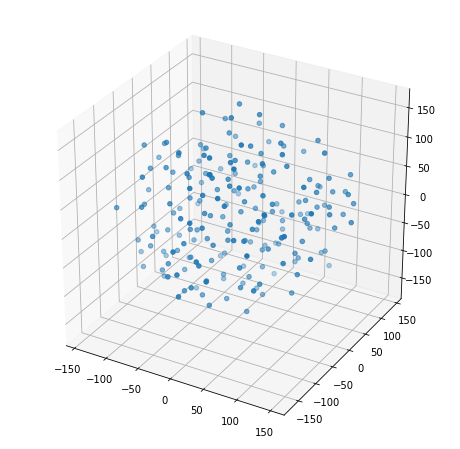

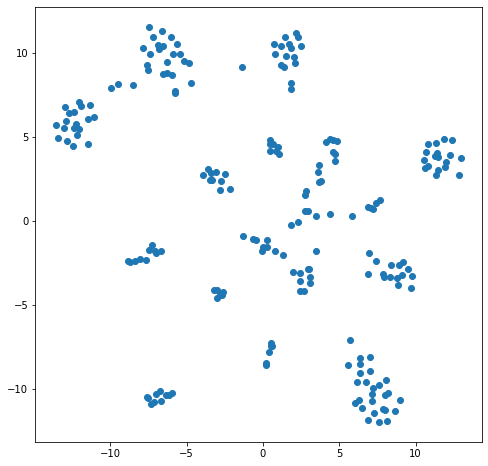

In [228]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
E,A,P,plot1,plot2,plot3=testKNN2(M,Xte,Yte,Xte.shape[0],XX)
print("Error is "+str(E))
print("Accuracy is "+str(A))
print("Precision is "+str(P))

def plotting(X,k):
    X=TSNE(n_components=k).fit_transform(X)
    if(k==3):
        fig=plt.figure(figsize=(8,8))
        ax=fig.add_subplot(111,projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2])
    if(k==2):
        fig=plt.figure(figsize=(8,8))
        plt.scatter(X[:,0],X[:,1])
        
plotting(Xte,3)
plotting(Xte,2)

Images with true labels


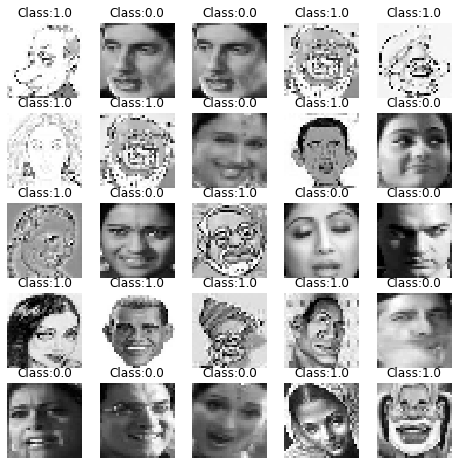




Images with predicted labels


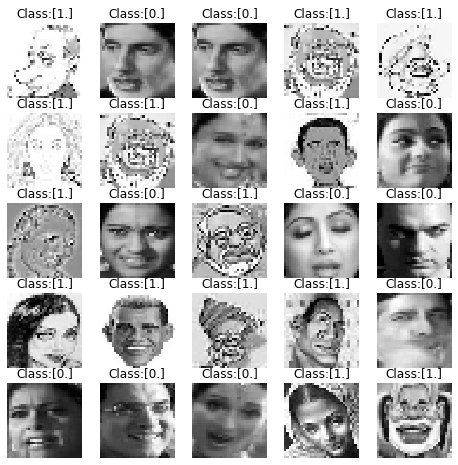

In [229]:
# Show quantitative results such as examples of correct prediction and wrong prediction
def di2(X1,y1,y2):
    """
    Display original images along with
    reconstructed ones.
    """
    N,R,C=[25,5,5]
    ind=np.random.randint(0,y1.shape[0],N)
    print("Images with true labels")
    disply_images(X1[ind,...],y1[ind],row=R,col=C)
    print("\n\n")
    print("Images with predicted labels")
    disply_images(X1[ind,...],y2[ind],row=R,col=C)
    

plot1=plot1.reshape((plot1.shape[0],32,32))
di2(plot1,plot2,plot3)


## <u>Theory related to this question</u>

### Problem Statement
Take a dataset of images and classify each image as cartoon like or real.
<br>
This problem could be solved easily in early days when the graphics industry was in its initial stages. But now we can easily generate high quality computer manufactured images with a lot more resemblance to reality which makes this this problem a difficult one to solve.

### Dataset used
IIIT-CFW combined with IMFD

### Real life application
Trustworthy photographs play an important role in many applications such as news reporting, intelligence information gathering, criminal investigation, security surveillance, as well as health care.
<br>
However, with the advent of digital age, the trustworthiness of pictures could no longer be taken for granted. Hence it is essential to classify images as true/real or fraud/cartoon-like.
<br>
A cartton-like image can be easily manipulated and if it enters into official records of some dataset, then it becomes a major problem.
<br>
This makes this project of great use which can be used at an initial stage of such a problem where it removes images which are certainly not real



### Pipeline
 - Load both the datasets and combine them
 - Create a class label array in which assign 1 to cartoon like images and 0 to real images
 - Get resnet features to improve the accuracy
 - Shuffle the dataset and split it into training and testing(80 20)
 - Get accuracy, precision and error after appling KNN
 - Plot TSNE graphs after converting into 2D/3D
 - Display results
 
### Split
 - Original data is split into as 80% fot training and 20% for testing
 - Since we have fairly large sample points(1072), chosing 80% points to train is good enough as we get a large number of points to properly train the model
 - Chosing 20% as testing dataset ensures we have enough points to test the model

### Evaluation metrics
 - Accuracy and precision is used to evaluate the model
 - A good model is expected to have both accuracy and precision close to 1
 
### Results
 - Accuracy is 1
 - Precision is 1
 - We get high accuracy and high precision due to the fact that all the data points are grouped together in the dimension space
 - Hence any chosen point would get its neighbours as the points in the cluster to which it belongs
 - This would result in very less chance of misclassification as every point would have atleast 3 neighbours in its neighbourhood
 